In [3]:
from keras.models import Sequential, Model
from keras.applications import MobileNet
from keras.preprocessing.image import ImageDataGenerator 
from keras.preprocessing import image 
from keras.utils import to_categorical
#from keras.applications.vgg19 import VGG19
from keras.layers import Dense, MaxPooling2D, Flatten, Activation, Dropout,GlobalAveragePooling2D
#from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import cv2
import keras
import matplotlib.pyplot as plt 
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [4]:
check_point  = ModelCheckpoint("face_emotion_mobilenet.h5",
                               monitor="val_loss",
                               mode = "min",
                               save_best_only=True,
                               verbose=1)
early_stop = EarlyStopping(monitor="val_loss",
                          min_delta=0,
                          patience=10,
                          verbose=1,restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy",
                                           patience=5,
                                           verbose=1,
                                           factor=0.2,
                                           min_lr=0.0001)
callbacks = [early_stop,check_point,learning_rate_reduction]

In [5]:
num_class = 5
r,c = (224,224)
batch_size = 32
train_data_dir = 'train'
valid_data_dir = 'validation'

train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=30,
                                  shear_range=0.3,
                                  zoom_range=0.3,
                                  width_shift_range=0.4,
                                  height_shift_range=0.4,
                                  horizontal_flip=True,
                                  fill_mode="nearest")

valid_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_data_dir,
                                              class_mode="categorical",
                                              target_size=(r,c),
                                              batch_size=batch_size)

valid_gen = valid_datagen.flow_from_directory(valid_data_dir,
                                              class_mode="categorical",
                                              target_size=(r,c),
                                              batch_size=batch_size)

Found 24256 images belonging to 5 classes.
Found 3006 images belonging to 5 classes.


In [7]:
m = MobileNet(weights='imagenet',include_top=False,input_shape=(r,c,3))
for layer in m.layers:
    layer.trainable = True 


17227776/17225924 [==============================] - 143s 8us/step


In [8]:
x = m.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
x = Dense(5,activation="softmax")(x)

In [9]:
model = Model(inputs=m.input, outputs=x)

In [10]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [11]:
model.compile(loss = "categorical_crossentropy",optimizer=keras.optimizers.Adam(lr=0.001),metrics=["accuracy"])
num_train = 24256
num_valid = 3006
epochs = 30
his = model.fit_generator(train_gen,
                     steps_per_epoch = num_train//batch_size,
                     epochs = epochs,callbacks=callbacks,
                     validation_data = valid_gen,
                     validation_steps = num_valid//batch_size)

Epoch 1/30
758/758 [==============================] - 1021s 1s/step - loss: 1.2474 - accuracy: 0.4884 - val_loss: 1.6102 - val_accuracy: 0.5360

Epoch 00001: val_loss improved from inf to 1.61020, saving model to face_emotion_mobilenet.h5
Epoch 2/30
758/758 [==============================] - 489s 645ms/step - loss: 1.0598 - accuracy: 0.5791 - val_loss: 1.0389 - val_accuracy: 0.5578

Epoch 00002: val_loss improved from 1.61020 to 1.03894, saving model to face_emotion_mobilenet.h5
Epoch 3/30
758/758 [==============================] - 492s 649ms/step - loss: 0.9989 - accuracy: 0.6056 - val_loss: 1.0249 - val_accuracy: 0.5713

Epoch 00003: val_loss improved from 1.03894 to 1.02492, saving model to face_emotion_mobilenet.h5
Epoch 4/30
758/758 [==============================] - 475s 626ms/step - loss: 0.9536 - accuracy: 0.6296 - val_loss: 1.6263 - val_accuracy: 0.5918

Epoch 00004: val_loss did not improve from 1.02492
Epoch 5/30
758/758 [==============================] - 479s 633ms/step - l

In [13]:
model.save("Mobile_Net.h5")

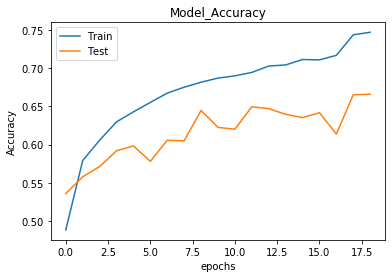

In [14]:
plt.plot(his.history["accuracy"])
plt.plot(his.history["val_accuracy"])
plt.title("Model_Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("epochs")
plt.legend(['Train',"Test"],loc="upper left")
plt.show()

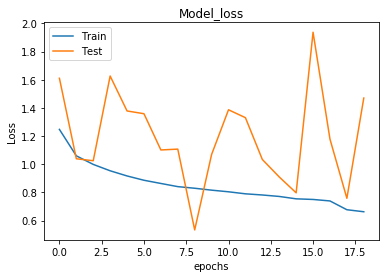

In [15]:
plt.plot(his.history["loss"])
plt.plot(his.history["val_loss"])
plt.title("Model_loss")
plt.ylabel("Loss")
plt.xlabel("epochs")
plt.legend(['Train',"Test"],loc="upper left")
plt.show()

In [18]:
y_pred = model.predict_generator(valid_gen,num_valid//batch_size+1)
y_pred = np.argmax(y_pred,axis=1)
print("Confution matrix")
print(confusion_matrix(valid_gen.classes,y_pred))

Confution matrix
[[119 166  50  79  77]
 [183 315  91 141 149]
 [127 219  75  98 107]
 [118 217  65  93 101]
 [ 87 146  50  74  59]]
